In [22]:
from datetime import date, datetime
from typing import Union
import  matplotlib.pylab as plt
import demeter as dt
import demeter.indicator
from demeter import TokenInfo, PoolBaseInfo, Runner, Strategy, Asset, AccountStatus, BuyAction, SellAction, RowData, \
    ChainType
import numpy as np
import pandas as pd
from decimal import Decimal

# import logging 
# from logging import handlers

from strategy_ploter import  plot_position_return_decomposition

%matplotlib inline

# logger = logging.getLogger()
# logger.setLevel(logging.INFO) 
# logFile = './temp/hedge.log'


# # 创建一个FileHandler,并将日志写入指定的日志文件中
# fileHandler = logging.FileHandler(logFile, mode='a')
# fileHandler.setLevel(logging.INFO) 
 
# #  或者创建一个StreamHandler,将日志输出到控制台
# streamHandler = logging.StreamHandler()
# streamHandler.setLevel(logging.INFO)

# # 定义Handler的日志输出格式
# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# fileHandler.setFormatter(formatter)
 
# # 定义日志滚动条件，这里按日期-天保留日志
# timedRotatingFileHandler = handlers.TimedRotatingFileHandler(filename=logFile, when='D')
# timedRotatingFileHandler.setLevel(logging.INFO)
# timedRotatingFileHandler.setFormatter(formatter)

# # 添加Handler
# logger.addHandler(fileHandler)
# logger.addHandler(streamHandler)
# logger.addHandler(timedRotatingFileHandler)

class Exchange:


    def __init__(self, trade_symbols, leverage=20, commission=0.00005,  initial_balance=10000, log=False):
        self.initial_balance = initial_balance #初始的资产
        self.commission = Decimal(commission)
        self.leverage = leverage
        self.trade_symbols = trade_symbols
        self.date = ''
        self.log = log
        self.df = pd.DataFrame(columns=['margin','total','leverage','realised_profit','unrealised_profit'])
        self.df.index.name='timestamp'
        self.account = {'USDT':{'realised_profit':0, 'margin':0, 'unrealised_profit':0, 'total':initial_balance, 'leverage':0, 'fee':0}}
        #保存symbol的eth price和diff
        self.symbol_diff = {}
        self.symbol_single_diff = {}
        self.symbol_boll = {}
        for symbol in trade_symbols:
            self.account[symbol] = {'amount':0, 'hold_price':0, 'value':0, 'price':0, 'realised_profit':0, 'margin':0, 'unrealised_profit':0,'fee':0}
            self.symbol_diff[symbol] = pd.DataFrame(columns=['symbol','index_price','symbol_index_price','diff'])
            # self.symbol_diff[symbol].index = pd.to_datetime(price_usdt.index)

            self.symbol_single_diff[symbol] = pd.DataFrame(columns=['symbol','normal_index_price','ema_index_price','symbol_price','diff_norm','diff_ewa'])
            # self.symbol_single_diff[symbol].index = pd.to_datetime(price_usdt.index)
            self.symbol_boll[symbol] = pd.DataFrame(columns=['symbol','normal_index_price','symbol_price','std'])

    def Trade(self, symbol, direction, price, amount, msg=''):
        if self.date and self.log:
            print('%-20s%-5s%-5s%-10.8s%-8.6s %s'%(str(self.date), symbol, 'buy' if direction == 1 else 'sell', price, amount, msg))
            
        cover_amount = 0 if direction*self.account[symbol]['amount'] >=0 else min(abs(self.account[symbol]['amount']), amount)
        open_amount = amount - cover_amount
        
        self.account['USDT']['realised_profit'] -= price*amount*self.commission #扣除手续费
        self.account['USDT']['fee'] += price*amount*self.commission
        self.account[symbol]['fee'] += price*amount*self.commission
        
        if cover_amount > 0: #先平仓
            self.account['USDT']['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount  #利润
            self.account['USDT']['margin'] -= cover_amount*self.account[symbol]['hold_price']/self.leverage #释放保证金
            
            self.account[symbol]['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount
            self.account[symbol]['amount'] -= -direction*cover_amount
            self.account[symbol]['margin'] -=  cover_amount*self.account[symbol]['hold_price']/self.leverage
            self.account[symbol]['hold_price'] = 0 if self.account[symbol]['amount'] == 0 else self.account[symbol]['hold_price']
            
        if open_amount > 0:
            total_cost = self.account[symbol]['hold_price']*direction*self.account[symbol]['amount'] + price*open_amount
            total_amount = direction*self.account[symbol]['amount']+open_amount
            
            self.account['USDT']['margin'] +=  open_amount*price/self.leverage            
            self.account[symbol]['hold_price'] = total_cost/total_amount
            self.account[symbol]['amount'] += direction*open_amount
            self.account[symbol]['margin'] +=  open_amount*price/self.leverage
            
        self.account[symbol]['unrealised_profit'] = (price - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
        self.account[symbol]['price'] = price
        self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*price
        
        return True
    
    def Buy(self, symbol, price, amount, msg=''):
        self.Trade(symbol, 1, price, amount, msg)
        
    def Sell(self, symbol, price, amount, msg=''):
        self.Trade(symbol, -1, price, amount, msg)
        
    def Update(self, date, close_price): #对资产进行更新
        self.date = date
        # todo close price为单个close price
        self.close = close_price
        self.account['USDT']['unrealised_profit'] = 0
        for symbol in self.trade_symbols:
            # if np.isnan(close_price[symbol]):
            #     continue
            self.account[symbol]['unrealised_profit'] = (close_price - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
            self.account[symbol]['price'] = close_price
            self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*close_price
            self.account['USDT']['unrealised_profit'] += self.account[symbol]['unrealised_profit']
        
        self.account['USDT']['total'] = round(self.account['USDT']['realised_profit'] + self.initial_balance + self.account['USDT']['unrealised_profit'],6)
        self.account['USDT']['leverage'] = round(self.account['USDT']['margin']/self.account['USDT']['total'],4)*self.leverage
        self.df.loc[self.date] = [self.account['USDT']['margin'],self.account['USDT']['total'],self.account['USDT']['leverage'],self.account['USDT']['realised_profit'],self.account['USDT']['unrealised_profit']]

    def UpdateDiff(self, date, symbol,index_price,symbol_index_price,diff): 
        
        self.symbol_diff[symbol].loc[self.date] = [symbol,index_price,symbol_index_price,diff]

    def UpdateSingleDiff(self, date, symbol,normal_index_price,ema_index_price, symbol_price, diff_norm, diff_ewa): 
        
        self.symbol_single_diff[symbol].loc[self.date] = [symbol,normal_index_price,ema_index_price,symbol_price, diff_norm, diff_ewa]

    def UpdateBoll(self, date, symbol, normal_index_price, symbol_price, std): 
        
        self.symbol_boll[symbol].loc[self.date] = [symbol,normal_index_price,symbol_price, std]

ETH = TokenInfo(name="eth", decimal=18)
usdc = TokenInfo(name="usdc", decimal=6)


class ConstantInterval(dt.Strategy):
    MIN_TRADE_AMOUNT = 0.01

    def __init__(self, a=1.25, trade_symbol='ETH'):
        super().__init__()
        self.a = Decimal(a)
        self.trade_symbol = trade_symbol
        self.init_quote_number = 0
        self.hedge_spread = 0
        self.hedge_amount = 0
        #init balance
        self.init_total_symbol = 0
        self.init_total_usdc = 0
        self.up_price = 0
        self.down_price = 0

    def initialize(self):
        P0 = self.broker.pool_status.price

        status: AccountStatus = self.broker.get_account_status(P0)

        
        future_init_net_value = status.net_value * Decimal(0.2)
        
        self.e = Exchange({self.trade_symbol},initial_balance=future_init_net_value,commission=0.00075,log=False)


        self.init_total_usdc = status.net_value + future_init_net_value
        self.init_total_symbol =  self.init_total_usdc / P0
       
        self.rebalance(P0)#rebalance all reserve token#
        # new_position(self, baseToken, quoteToken, usd_price_a, usd_price_b):
        #what is  base/quote "https://corporatefinanceinstitute.com/resources/knowledge/economics/currency-pair/"
        # print(P0)
        self.down_price = P0 / self.a
        self.up_price = P0 * self.a
        print(f"prepare to add LP: rate:{self.a} price:{P0} down:{self.down_price} up:{self.up_price} init symbol amount:{self.init_total_symbol},init usdc amount:{self.init_total_usdc}")
        self.add_liquidity(self.down_price, self.up_price)

        print("eth_value",self.broker.quote_asset.balance, "usdc value", self.broker.base_asset.balance)
        account_status = self.broker.get_account_status()
        self.init_quote_number = account_status.quote_in_position

        self.hedge_spread = self.init_quote_number / 3 
        self.hedge_amount = self.hedge_spread * Decimal(0.8)

        # price = self.broker.pool_status.price
        # self.hedge_rebalance(price, self.init_quote_number)
        # symbol = self.trade_symbol
        # print(f"{symbol}, {self.hedge_spread}")
        # e = self.e
        # e.Buy(symbol, price, trade_amount, round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))


        # print(self.broker.get_account_status())
        # super().__init__()
    # def initialize(self):
    #     P0 = self.broker.pool_status.price
    #     self.rebalance(P0)#rebalance all reserve token#
    #     # new_position(self, baseToken, quoteToken, usd_price_a, usd_price_b):
    #     #what is  base/quote "https://corporatefinanceinstitute.com/resources/knowledge/economics/currency-pair/"
    #     self.add_liquidity(P0 - self.a,
    #                        P0 + self.a)
    #     print("eth_value",self.broker.quote_asset.balance)
    #     super().__init__()
    def hedge_rebalance(self, price, spot_amount_traded):
        e = self.e
        symbol = self.trade_symbol
        future_amount = e.account[symbol]['amount']
        amount_diff = future_amount - spot_amount_traded
        if amount_diff > 0:
            
            e.Sell(symbol, price, abs(amount_diff), round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
        elif amount_diff < 0:
            e.Buy(symbol, price, abs(amount_diff), round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))

        print(f"hedge rebalance {symbol} {amount_diff} {price} profit: {e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit']}")
        # print(self.broker.get_account_status())


    def next(self, row_data: Union[RowData, pd.Series]):
        # print(row_data.price)
        # if row_data.timestamp.minute != 0:
        #     return
        # print("eth_value",self.broker.quote_asset.balance, "usdc value", self.broker.base_asset.balance)
        # for position_info, position in self.broker.positions.items():
        #         print(position_info, position)  # show all position
        e = self.e

        e.Update(row_data.timestamp,row_data.price)

        current_amount = self.broker.get_account_status().quote_in_position
        usdc_amount = self.broker.get_account_status().base_in_position
        future_amount = self.e.account[self.trade_symbol]['amount']
        spread = self.init_quote_number*2 -current_amount - future_amount
        symbol = self.trade_symbol
        price = row_data.price

        # todo 处理价格跑出范围
        # print(f"====>rowdata.low:{row_data.low} rowdata.high:{row_data.high} rowdata.price:{row_data.price} rowdata.timestamp:{row_data.timestamp}")
        # todo row_data.low 大于 row_data.high
        if row_data.high < self.down_price:
            print(f"====>high:{row_data.high}, self.down_price:{self.down_price}")
            amount_down = self.broker.get_account_status(self.down_price).quote_in_position
            trade_amount = abs(self.init_quote_number*2 - amount_down - future_amount)
            if trade_amount >= self.MIN_TRADE_AMOUNT:
                trade_price = self.down_price
                e.Sell(symbol, trade_price, trade_amount, round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
                print(f"{row_data.timestamp } last hedge sell {symbol}, trade_price:{trade_price}, trade_amount: {trade_amount}, current_amount: {current_amount}")
        elif row_data.low > self.up_price:
            print(f"====>low:{row_data.low}, self.up_price:{self.up_price}")

            amount_up = 0
            trade_amount = self.init_quote_number*2 - future_amount
            if trade_amount >= self.MIN_TRADE_AMOUNT:
                trade_price = self.up_price

                e.Buy(symbol, trade_price, abs(trade_amount), round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
                print(f"{row_data.timestamp } last hedge buy {symbol}, {trade_price}, trade_amount: {trade_amount}, current_amount: {current_amount}")
 
        if current_amount == 0 or usdc_amount == 0:
            # out of range, hedge at first
            # if spread > 0:
            #     trade_amount = spread
            #     e.Buy(symbol, price, trade_amount, round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
            #     print(f"{row_data.timestamp} last hedge buy {symbol}, {price}, {trade_amount}, {round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2)}")
            # else:
            #     trade_amount = spread * -1
            #     e.Sell(symbol, price, trade_amount, round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
            #     print(f"{row_data.timestamp } last hedge sell {symbol}, {price}, {trade_amount}, {round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2)}")


            if len(self.broker.positions) > 0:
                keys = list(self.broker.positions.keys())
                for k in keys:
                    print(f"remove lp position {k}")
                    self.remove_liquidity(k)
            print(f"{row_data.timestamp} out of range, {price}, symbol:{current_amount}, usdc:{usdc_amount}")
            self.rebalance(price)
            self.down_price = price / self.a
            self.up_price = price * self.a
            print(f"prepare to add LP: rate:{self.a} price:{price} {self.down_price} { self.up_price} ")
            self.add_liquidity(self.down_price, self.up_price)
        else:
            if spread > self.hedge_spread:
                trade_amount = self.hedge_amount
                e.Buy(symbol, price, trade_amount, round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
                print(f"{row_data.timestamp} hedge buy {symbol}, {price}, {trade_amount}, {round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2)}")
            elif Decimal(-1)*self.hedge_spread >= spread:
                trade_amount = self.hedge_amount
                e.Sell(symbol, price, trade_amount, round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2))
                print(f"{row_data.timestamp } hedge sell {symbol},trade price: {price},trade amount: {trade_amount}, profit: {round(e.account[symbol]['realised_profit']+e.account[symbol]['unrealised_profit'],2)}")

        # print(f"spread:{spread}, {self.hedge_spread}")
        # print(f"spread: {spread},{self.init_quote_number},{current_amount},{future_amount}")
        # print(self.data.timestamp[row_data.row_id]) 
            # if row_data.timestamp.minute != 0:
            #     return
            # if len(self.broker.positions) > 0:
            #     keys = list(self.broker.positions.keys())
            #     for k in keys:
            #         self.remove_liquidity(k)
            #     self.rebalance(row_data.price)
            # ma_price = row_data.ma5 if row_data.ma5 > 0 else row_data.price
            # self.add_liquidity(ma_price - self.price_width,
            #                 ma_price + self.price_width)
    #重新计算并全仓入池
    def rebalance(self, price):
        status: AccountStatus = self.broker.get_account_status(price)
        # self.init_total_symbol =  status.net_value / price
        # self.init_total_usdc = status.net_value
        # print(f"net value rebalance:{status.net_value}")
        base_amount = status.net_value / 2
        quote_amount = base_amount / price
        quote_amount_diff = quote_amount - status.quote_balance
        # print(f"rebalance: {status}, ")
        if quote_amount_diff > 0:
            self.buy(quote_amount_diff)
        elif quote_amount_diff < 0:
            self.sell(0 - quote_amount_diff)
        
        self.hedge_rebalance(price, quote_amount)

pool_id_tie500 = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'

pool_id_tie3000 = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'

eth = TokenInfo(name="eth", decimal=18)
usdc = TokenInfo(name="usdc", decimal=6)
pool = PoolBaseInfo(usdc, eth, 0.05, usdc)

net_value_base = 'ETH'

runner_instance = Runner(pool)
# runner_instance.enable_notify = False
runner_instance.strategy = ConstantInterval(a=1.20)
runner_instance.set_assets([Asset(usdc, 10000)])
runner_instance.data_path = "../demeter/data"
runner_instance.load_data(ChainType.Ethereum.name,
                              pool_id_tie500,
                              date(2022, 9, 1),
                              date(2022, 10, 30))
runner_instance.run(enable_notify=False)
print(runner_instance.final_status.net_value)
# plot_position_return_decomposition(runner_instance.account_status_list)

# df = pd.DataFrame(runner_instance.account_status_list)

# exchange = runner_instance.strategy.e

# exchange
df_status = pd.DataFrame(runner_instance.account_status_list)

df_status
# df



2022-11-02 15:18:28,367 - INFO - start load files...
start load files...
start load files...
start load files...
2022-11-02 15:18:29,275 - INFO - load file complete, preparing...
load file complete, preparing...
load file complete, preparing...
load file complete, preparing...
2022-11-02 15:18:35,095 - INFO - data has benn prepared
data has benn prepared
data has benn prepared
data has benn prepared
2022-11-02 15:18:35,102 - INFO - init strategy...
init strategy...
init strategy...
init strategy...
2022-11-02 15:18:35,121 - INFO - start main loop...
start main loop...
start main loop...
start main loop...


hedge rebalance ETH -3.218958783469115091478799439 1553.297303984561393232200930 profit: 0E-51
prepare to add LP: rate:1.1999999999999999555910790149937383830547332763671875 price:1553.297303984561393232200930 down:1294.414419987134542263123858 up:1863.956764781473602898383877 init symbol amount:7.725501080325876291024361786,init usdc amount:12000.00000000000011102230246
eth_value 0 usdc value 0.118199317661621369446356


  8%|█████████                                                                                                  | 7285/86400 [00:26<06:57, 189.29it/s]

2022-09-06 00:45:00 hedge buy ETH, 1648.188818964285043205740360, 0.8583890089250974053778419393, 305.45


 10%|██████████▊                                                                                                | 8717/86400 [00:32<04:43, 273.63it/s]

2022-09-07 00:21:00 hedge sell ETH,trade price: 1530.325884747905319582988915,trade amount: 0.8583890089250974053778419393, profit: -175.12


 11%|████████████▎                                                                                              | 9923/86400 [00:37<07:13, 176.27it/s]

2022-09-07 20:49:00 hedge buy ETH, 1653.140561738705663028663412, 0.8583890089250974053778419393, 220.22


 14%|███████████████                                                                                           | 12327/86400 [00:50<04:50, 254.89it/s]

2022-09-09 12:37:00 hedge buy ETH, 1735.289788823240471746622295, 0.8583890089250974053778419393, 555.17


 21%|██████████████████████▏                                                                                   | 18103/86400 [01:25<07:34, 150.12it/s]

2022-09-13 13:17:00 hedge sell ETH,trade price: 1606.211482251090805641989279,trade amount: 0.8583890089250974053778419393, profit: -81.93


 24%|█████████████████████████▊                                                                                | 21077/86400 [01:44<06:11, 176.01it/s]

2022-09-15 14:36:00 hedge sell ETH,trade price: 1531.703729090063450161456898,trade amount: 0.8583890089250974053778419393, profit: -385.72
2022-09-15 15:16:00 hedge sell ETH,trade price: 1465.333525692250687303728236,trade amount: 0.8583890089250974053778419393, profit: -599.36


 29%|███████████████████████████████▎                                                                          | 25485/86400 [02:16<07:25, 136.70it/s]

2022-09-18 16:16:00 hedge sell ETH,trade price: 1399.878103629018299367289161,trade amount: 0.8583890089250974053778419393, profit: -753.88


 30%|███████████████████████████████▌                                                                          | 25776/86400 [02:18<07:32, 134.05it/s]

2022-09-18 21:10:00 hedge sell ETH,trade price: 1337.881548272906751137845774,trade amount: 0.8583890089250974053778419393, profit: -847.01


 30%|████████████████████████████████                                                                          | 26121/86400 [02:21<08:11, 122.52it/s]

====>low:1293.160379365134677055374732, self.down_price:1294.414419987134542263123858
2022-09-19 03:01:00 last hedge sell ETH, trade_price:1294.414419987134542263123858, trade_amount: 0.9491251454191329676098397737, current_amount: 6.73111670364963402498401519


 30%|████████████████████████████████                                                                          | 26150/86400 [02:21<07:58, 125.89it/s]

====>low:1291.738756063969104407114015, self.down_price:1294.414419987134542263123858
====>low:1292.643244503567934387942742, self.down_price:1294.414419987134542263123858
remove lp position tick:201015,204662, liquidity:1455532611141913
2022-09-19 03:44:00 out of range, 1292.901786078901064534826108, symbol:6.743250955663540275222165026, usdc:0
hedge rebalance ETH -3.817588694353917139817897425 1292.901786078901064534826108 profit: -874.5275112621326342776195360
prepare to add LP: rate:1.1999999999999999555910790149937383830547332763671875 price:1292.901786078901064534826108 1077.418155065750926984836520 1551.482143294681220025418070 


 35%|████████████████████████████████████▉                                                                     | 30108/86400 [02:55<07:54, 118.59it/s]

2022-09-21 21:27:00 hedge sell ETH,trade price: 1256.450357460141512958499123,trade amount: 0.8583890089250974053778419393, profit: -1002.55


 35%|█████████████████████████████████████▏                                                                    | 30320/86400 [02:56<06:42, 139.32it/s]

2022-09-22 01:00:00 hedge sell ETH,trade price: 1112.707954773385056588259532,trade amount: 0.8583890089250974053778419393, profit: -1384.03


 36%|█████████████████████████████████████▊                                                                    | 30773/86400 [03:00<06:40, 138.76it/s]

2022-09-22 08:29:00 hedge buy ETH, 1289.286905014016281264190699, 0.8583890089250974053778419393, -1066.98


 37%|███████████████████████████████████████▏                                                                  | 31946/86400 [03:09<06:28, 140.02it/s]

2022-09-23 04:26:00 hedge buy ETH, 1346.067157169958579055478783, 0.8583890089250974053778419393, -916.30


 46%|████████████████████████████████████████████████▍                                                         | 39505/86400 [04:22<06:27, 120.99it/s]

2022-09-28 10:05:00 hedge sell ETH,trade price: 1259.721215121849415131787264,trade amount: 0.8583890089250974053778419393, profit: -1219.57


 46%|████████████████████████████████████████████████▉                                                         | 39876/86400 [04:25<06:20, 122.39it/s]

2022-09-28 16:14:00 hedge buy ETH, 1354.302848372952955366291444, 0.8583890089250974053778419393, -968.56


 53%|████████████████████████████████████████████████████████▉                                                  | 45926/86400 [05:35<08:02, 83.88it/s]

2022-10-02 21:12:00 hedge sell ETH,trade price: 1216.152514180674217192774510,trade amount: 0.8583890089250974053778419393, profit: -1453.78


 56%|███████████████████████████████████████████████████████████▍                                               | 47978/86400 [05:58<06:53, 92.90it/s]

2022-10-04 07:19:00 hedge buy ETH, 1347.009686901197513934972620, 0.8583890089250974053778419393, -1106.50


 71%|███████████████████████████████████████████████████████████████████████████▋                               | 61108/86400 [09:14<05:36, 75.26it/s]

2022-10-13 10:20:00 hedge sell ETH,trade price: 1260.351201714129624651819840,trade amount: 0.8583890089250974053778419393, profit: -1410.87


 71%|███████████████████████████████████████████████████████████████████████████▊                               | 61242/86400 [09:16<05:19, 78.68it/s]

2022-10-13 12:31:00 hedge sell ETH,trade price: 1206.100723528044203114698292,trade amount: 0.8583890089250974053778419393, profit: -1554.84


 71%|████████████████████████████████████████████████████████████████████████████▎                              | 61629/86400 [09:22<06:37, 62.39it/s]

2022-10-13 18:57:00 hedge buy ETH, 1289.415833704517668692868728, 0.8583890089250974053778419393, -1405.25


 78%|███████████████████████████████████████████████████████████████████████████████████▉                       | 67734/86400 [10:58<03:57, 78.73it/s]

2022-10-18 00:40:00 hedge buy ETH, 1352.543486469698932871275838, 0.8583890089250974053778419393, -1237.72


 84%|██████████████████████████████████████████████████████████████████████████████████████████                 | 72745/86400 [12:58<03:55, 57.88it/s]

2022-10-21 12:13:00 hedge sell ETH,trade price: 1256.701660096137088184126490,trade amount: 0.8583890089250974053778419393, profit: -1574.34


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▍            | 76218/86400 [13:54<02:24, 70.56it/s]

2022-10-23 22:01:00 hedge buy ETH, 1349.436366362012565717183855, 0.8583890089250974053778419393, -1328.23


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 78714/86400 [14:39<03:48, 33.67it/s]

2022-10-25 15:50:00 hedge buy ETH, 1408.443028285200422886694133, 0.8583890089250974053778419393, -1120.99


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▌         | 78798/86400 [14:40<01:36, 78.54it/s]

2022-10-25 17:08:00 hedge buy ETH, 1472.825440227956720144154117, 0.8583890089250974053778419393, -839.59


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 78910/86400 [14:42<01:52, 66.54it/s]

====>up:1587.053082654424332579145169, self.up_price:1551.482143294681220025418070
2022-10-25 18:56:00 last hedge buy ETH, 1551.482143294681220025418070, trade_amount: 1.208884243459428324648583723, current_amount: 0.6231609013144499735963554722


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▊         | 78992/86400 [14:43<01:45, 70.22it/s]

2022-10-25 20:19:00 hedge sell ETH,trade price: 1462.844699239669913762965746,trade amount: 0.8583890089250974053778419393, profit: -998.94


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 79856/86400 [14:57<01:30, 72.32it/s]

====>up:1571.891025464279860359396120, self.up_price:1551.482143294681220025418070
2022-10-26 10:44:00 last hedge buy ETH, 1551.482143294681220025418070, trade_amount: 0.858389008925097405377841939, current_amount: 0.1363462800130178116826715217


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▏       | 80059/86400 [15:00<01:26, 73.10it/s]

====>up:1551.900035138545047913795616, self.up_price:1551.482143294681220025418070
====>up:1556.873820378170063992228821, self.up_price:1551.482143294681220025418070
remove lp position tick:202850,206497, liquidity:1448932236964495
2022-10-26 14:13:00 out of range, 1556.251226506268874114418743, symbol:0, usdc:9513.213269953754593491365977
hedge rebalance ETH 3.185692045039551954638765283 1556.251226506268874114418743 profit: -473.6782399189075079863834858
prepare to add LP: rate:1.1999999999999999555910790149937383830547332763671875 price:1556.251226506268874114418743 1296.876022088557443089402946 1867.501471807522579825864741 


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 82201/86400 [15:38<01:19, 52.86it/s]

2022-10-28 01:53:00 hedge sell ETH,trade price: 1474.888736651682159165831070,trade amount: 0.8583890089250974053778419393, profit: -738.29


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 83727/86400 [16:05<00:30, 86.28it/s]

2022-10-29 03:16:00 hedge buy ETH, 1588.958594157874233603513626, 0.8583890089250974053778419393, -465.22


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 84600/86400 [16:19<00:40, 44.39it/s]

2022-10-29 17:51:00 hedge buy ETH, 1660.264014435278814979427078, 0.8583890089250974053778419393, -233.32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400/86400 [16:59<00:00, 84.76it/s]
2022-11-02 15:35:34,455 - INFO - main loop finished, start calculate evaluating indicator...
main loop finished, start calculate evaluating indicator...
main loop finished, start calculate evaluating indicator...
main loop finished, start calculate evaluating indicator...
2022-11-02 15:35:34,641 - INFO - run evaluating indicator
run evaluating indicator
run evaluating indicator
run evaluating indicator
2022-11-02 15:35:34,663 - INFO - back testing finish
back testing finish
back testing finish
back testing finish


10317.739usdc


,timestamp,base_balance,quote_balance,uncollect_fee_base,uncollect_fee_quote,base_in_position,quote_in_position,net_value,price
0,2022-09-01 00:00:00,0.11819932usdc,0eth,0.000080093972usdc,0.0000084771250eth,4997.3818usdc,3.2189588eth,9997.5132usdc,1553.2973usdc/eth
1,2022-09-01 00:01:00,0.11819932usdc,0eth,0.016173098usdc,0.000022416509eth,4985.9105usdc,3.2263454eth,9995.5492usdc,1552.6761usdc/eth
2,2022-09-01 00:02:00,0.11819932usdc,0eth,0.078993946usdc,0.000022416509eth,5115.0954usdc,3.1433309eth,10017.913usdc,1559.6786usdc/eth
3,2022-09-01 00:03:00,0.11819932usdc,0eth,0.078993946usdc,0.000022416509eth,5115.0954usdc,3.1433309eth,10017.913usdc,1559.6786usdc/eth
4,2022-09-01 00:04:00,0.11819932usdc,0eth,0.094755417usdc,0.000034517663eth,5106.4740usdc,3.1488594eth,10016.476usdc,1559.2108usdc/eth
...,...,...,...,...,...,...,...,...,...
86395,2022-10-30 23:55:00,0.28401298usdc,0eth,46.623945usdc,0.029123392eth,5709.6822usdc,2.8385172eth,10319.992usdc,1591.3437usdc/eth
86396,2022-10-30 23:56:00,0.28401298usdc,0eth,46.631504usdc,0.029123544eth,5724.3632usdc,2.8292940eth,10322.278usdc,1592.1395usdc/eth
86397,2022-10-30 23:57:00,0.28401298usdc,0eth,46.631504usdc,0.029129247eth,5724.3632usdc,2.8292940eth,10322.287usdc,1592.1395usdc/eth
86398,2022-10-30 23:58:00,0.28401298usdc,0eth,46.634030usdc,0.029137090eth,5695.0050usdc,2.8477427eth,10317.739usdc,1590.5483usdc/eth


In [23]:
e = runner_instance.strategy.e

In [24]:
total_net_value = runner_instance.final_status.net_value + runner_instance.final_status.uncollect_fee_base + runner_instance.final_status.uncollect_fee_quote * runner_instance.final_status.price
final_price = runner_instance.final_status.price
if net_value_base == 'USDC':
    profit = total_net_value- runner_instance.strategy.init_total_usdc
    profit_rate = profit / runner_instance.strategy.init_total_usdc
else:
    profit = total_net_value/final_price - runner_instance.strategy.init_total_symbol
    profit_rate = profit / runner_instance.strategy.init_total_symbol

profit_rate

Decimal('-0.1527586573917002054151386868')

In [26]:
df_status

,timestamp,base_balance,quote_balance,uncollect_fee_base,uncollect_fee_quote,base_in_position,quote_in_position,net_value,price
0,2022-09-01 00:00:00,0.11819932usdc,0eth,0.000080093972usdc,0.0000084771250eth,4997.3818usdc,3.2189588eth,9997.5132usdc,1553.2973usdc/eth
1,2022-09-01 00:01:00,0.11819932usdc,0eth,0.016173098usdc,0.000022416509eth,4985.9105usdc,3.2263454eth,9995.5492usdc,1552.6761usdc/eth
2,2022-09-01 00:02:00,0.11819932usdc,0eth,0.078993946usdc,0.000022416509eth,5115.0954usdc,3.1433309eth,10017.913usdc,1559.6786usdc/eth
3,2022-09-01 00:03:00,0.11819932usdc,0eth,0.078993946usdc,0.000022416509eth,5115.0954usdc,3.1433309eth,10017.913usdc,1559.6786usdc/eth
4,2022-09-01 00:04:00,0.11819932usdc,0eth,0.094755417usdc,0.000034517663eth,5106.4740usdc,3.1488594eth,10016.476usdc,1559.2108usdc/eth
...,...,...,...,...,...,...,...,...,...
86395,2022-10-30 23:55:00,0.28401298usdc,0eth,46.623945usdc,0.029123392eth,5709.6822usdc,2.8385172eth,10319.992usdc,1591.3437usdc/eth
86396,2022-10-30 23:56:00,0.28401298usdc,0eth,46.631504usdc,0.029123544eth,5724.3632usdc,2.8292940eth,10322.278usdc,1592.1395usdc/eth
86397,2022-10-30 23:57:00,0.28401298usdc,0eth,46.631504usdc,0.029129247eth,5724.3632usdc,2.8292940eth,10322.287usdc,1592.1395usdc/eth
86398,2022-10-30 23:58:00,0.28401298usdc,0eth,46.634030usdc,0.029137090eth,5695.0050usdc,2.8477427eth,10317.739usdc,1590.5483usdc/eth


In [27]:
e.account

{'USDT': {'realised_profit': Decimal('-908.6070187563639094275813986'),
  'margin': Decimal('309.5115127791661256668335682'),
  'unrealised_profit': Decimal('347.9005667276331988688620358'),
  'total': Decimal('1439.293548'),
  'leverage': Decimal('4.3000'),
  'fee': Decimal('40.81038325290062880464964104')},
 'ETH': {'amount': Decimal('4.110614530823775633696675530'),
  'hold_price': Decimal('1505.913582790451430964273897'),
  'value': Decimal('6538.130822310955712205533405'),
  'price': Decimal('1590.548267974107707158329230'),
  'realised_profit': Decimal('-867.7966355034632806229317575'),
  'margin': Decimal('309.5115127791661256668335682'),
  'unrealised_profit': Decimal('347.9005667276331988688620358'),
  'fee': Decimal('40.81038325290062880464964104')}}

In [28]:
df_merge = pd.merge(e.df, df_status, on='timestamp', how='inner')

df_merge['total_value'] = df_merge['total'] + df_merge['uncollect_fee_base'] + df_merge['uncollect_fee_quote'] * df_merge['price'] + df_merge['net_value']

df_merge.set_index('timestamp', inplace=True)

df_merge['total_value_eth'] = df_merge['total_value'] / df_merge['price']

df_merge['total_value_eth_profit_rate'] = df_merge['total_value_eth'] / runner_instance.strategy.init_total_symbol

df_merge

,margin,total,leverage,realised_profit,unrealised_profit,base_balance,quote_balance,uncollect_fee_base,uncollect_fee_quote,base_in_position,quote_in_position,net_value,price,total_value,total_value_eth,total_value_eth_profit_rate
timestamp,,,,,,,,,,,,,,,,
2022-09-01 00:00:00,250.000000000000000000000000,1996.250000,2.5040,-3.750000000000000078062556419,0E-51,0.11819932usdc,0eth,0.000080093972usdc,0.0000084771250eth,4997.3818usdc,3.2189588eth,9997.5132usdc,1553.2973usdc/eth,11993.77649517863822492782092,7.721494439224139245164588016,0.9994813745982198428302581206
2022-09-01 00:01:00,250.000000000000000000000000,1994.250500,2.5080,-3.750000000000000078062556419,-1.999500099982282641433086133,0.11819932usdc,0eth,0.016173098usdc,0.000022416509eth,4985.9105usdc,3.2263454eth,9995.5492usdc,1552.6761usdc/eth,11989.85066332852319688330112,7.722055071018183039888550687,0.9995539435860711973486576286
2022-09-01 00:02:00,250.000000000000000000000000,2016.791053,2.4800,-3.750000000000000078062556419,20.54105335067022559501212468,0.11819932usdc,0eth,0.078993946usdc,0.000022416509eth,5115.0954usdc,3.1433309eth,10017.913usdc,1559.6786usdc/eth,12034.81847106563155733583005,7.716217079638968835030010923,0.9987982655635696527229777192
2022-09-01 00:03:00,250.000000000000000000000000,2016.791053,2.4800,-3.750000000000000078062556419,20.54105335067022559501212468,0.11819932usdc,0eth,0.078993946usdc,0.000022416509eth,5115.0954usdc,3.1433309eth,10017.913usdc,1559.6786usdc/eth,12034.81847106563155733583005,7.716217079638968835030010923,0.9987982655635696527229777192
2022-09-01 00:04:00,250.000000000000000000000000,2015.285192,2.4820,-3.750000000000000078062556419,19.03519221693051060497938620,0.11819932usdc,0eth,0.094755417usdc,0.000034517663eth,5106.4740usdc,3.1488594eth,10016.476usdc,1559.2108usdc/eth,12031.91007382073226731627144,7.716666875357863521606167084,0.9988564877700282289140589306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-30 23:55:00,309.5115127791661256668335682,1442.563267,4.2920,-908.6070187563639094275813986,351.1702860172551249947467144,0.28401298usdc,0eth,46.623945usdc,0.029123392eth,5709.6822usdc,2.8385172eth,10319.992usdc,1591.3437usdc/eth,11855.52460207852309532755202,7.450008815378001606550728856,0.9643398839656554810652020043
2022-10-30 23:56:00,309.5115127791661256668335682,1445.834622,4.2820,-908.6070187563639094275813986,354.4416404935264896935496486,0.28401298usdc,0eth,46.631504usdc,0.029123544eth,5724.3632usdc,2.8292940eth,10322.278usdc,1592.1395usdc/eth,11861.11322192216776612682229,7.449795060162747704246797513,0.9643122151823582705620027359
2022-10-30 23:57:00,309.5115127791661256668335682,1445.834622,4.2820,-908.6070187563639094275813986,354.4416404935264896935496486,0.28401298usdc,0eth,46.631504usdc,0.029129247eth,5724.3632usdc,2.8292940eth,10322.287usdc,1592.1395usdc/eth,11861.13138279088136623443640,7.449806466743858555232644214,0.9643136916666655344003008330


/var/folders/jx/963_5qrj3ld11sfdq7x6c69m0000gn/T/ipykernel_42901/777635673.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


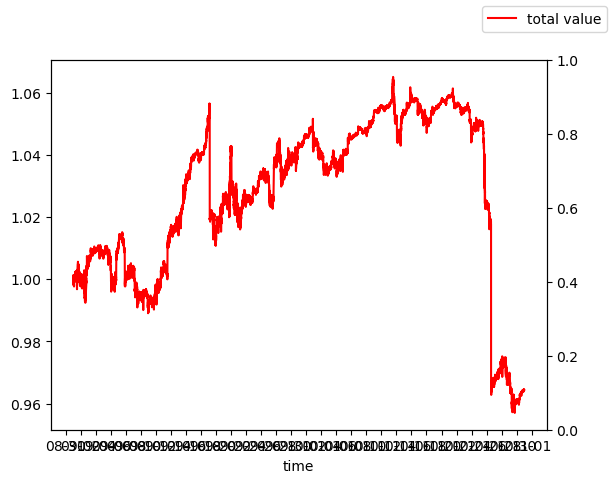

In [29]:
import matplotlib.dates as mdates

fig, value_ax = plt.subplots()
day = mdates.DayLocator(interval=2)
price_ax = value_ax.twinx()
price_ax.xaxis.set_major_locator(day)
price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

value_ax.set_xlabel('time')
# value_ax.set_ylabel('value', color='g')
# price_ax.set_ylabel('price', color='b')
# net_value_ts = df_merge['net_value']

time_ts = df_merge.index
total_value_ts = df_merge['total_value_eth_profit_rate']

# value_in_account = [status.base_balance+status.quote_balance*status.price for status in account_status_list]
# value_in_position = [ status.base_in_position+status.quote_in_position*status.price for status in account_status_list]
# value_ax.plot(time_ts[1:],net_value_ts[1:],'g-',label="net value")
value_ax.plot(time_ts,total_value_ts,'r-',label="total value profit rate")
#value_ax.plot(time_ts,value_in_account,'b-',label=" value_in broker account")
# price_ax.plot(time_ts,total_value_ts,label="total value")
fig.legend()
fig.show()